In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from keras.preprocessing.sequence import pad_sequences

import pandas as pd
import matplotlib as mpl
import matplotlib.pylab as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import keras.backend as K 

from keras.callbacks import EarlyStopping,ModelCheckpoint

from keras.utils import np_utils
from keras.models import Sequential, load_model

from keras.layers import BatchNormalization, Conv1D, LSTM,Input, Dense, Dropout,TimeDistributed, Flatten,MaxPooling1D
from keras.optimizers import Adam
from keras.models import Model

from keras.callbacks import ReduceLROnPlateau
from keras.applications.mobilenet import MobileNet, decode_predictions
from keras.applications.resnet50 import ResNet50, decode_predictions

from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, classification_report


import random

import ast
import os
import cv2
from collections import Counter

Using TensorFlow backend.


In [2]:
import winsound as ws

def beepsound():
    freq = 2000    # range : 37 ~ 32767
    dur = 1000     # ms
    ws.Beep(freq, dur) # winsound.Beep(frequency, duration)


# Data Preparation(1)

In [3]:
all_data = pd.read_pickle("new_true_split_data/dataset_1.pkl")

In [4]:
all_data.shape

(500000, 6)

In [5]:
word_lst = list(all_data['word'].unique())

In [6]:
train2, test = train_test_split(all_data, test_size=0.3, shuffle = True,
                                random_state = 42,
                                stratify = all_data["word"])

In [7]:
Counter(train2["word"])

Counter({'wine bottle': 17500,
         'pond': 17500,
         'cake': 17500,
         'traffic light': 17500,
         'sea turtle': 17500,
         'carrot': 17500,
         'microphone': 17500,
         'snake': 17500,
         'octopus': 17500,
         'mermaid': 17500,
         'chandelier': 17500,
         'dog': 17500,
         'bat': 17500,
         'television': 17500,
         'light bulb': 17500,
         'computer': 17500,
         'pliers': 17500,
         'candle': 17500,
         'monkey': 17500,
         'couch': 17500})

In [8]:
train, valid=  train_test_split(train2, test_size=0.3, shuffle = True, 
                                random_state = 42,
                                stratify = train2["word"])

In [9]:
Counter(all_data["word"])

Counter({'wine bottle': 25000,
         'candle': 25000,
         'computer': 25000,
         'pond': 25000,
         'light bulb': 25000,
         'traffic light': 25000,
         'bat': 25000,
         'carrot': 25000,
         'snake': 25000,
         'dog': 25000,
         'monkey': 25000,
         'television': 25000,
         'microphone': 25000,
         'sea turtle': 25000,
         'couch': 25000,
         'cake': 25000,
         'mermaid': 25000,
         'chandelier': 25000,
         'octopus': 25000,
         'pliers': 25000})

In [10]:
print(train.shape)
print(valid.shape)
print(test.shape)

(245000, 6)
(105000, 6)
(150000, 6)


In [11]:
word_le = LabelEncoder()
word_le.fit(all_data['word'])

LabelEncoder()

In [12]:
word_le.classes_

array(['bat', 'cake', 'candle', 'carrot', 'chandelier', 'computer',
       'couch', 'dog', 'light bulb', 'mermaid', 'microphone', 'monkey',
       'octopus', 'pliers', 'pond', 'sea turtle', 'snake', 'television',
       'traffic light', 'wine bottle'], dtype=object)

# Data Preparation(2)

* Input data 사용 가능하게 전처리([Kaggle](https://www.kaggle.com/kmader/quickdraw-baseline-lstm-reading-and-submission) 참조)

In [13]:
word_num = len(word_lst)
INPUT_DRAW = 200

In [46]:
def stroke_to_input(draw):
    
    if type(draw) != type([]):
        draw = eval(draw)
        
    # (x point, y point, order)의 형식으로 변환
    redraw_lst = []
    
    for i, (x,y) in enumerate(draw):
        for x2,y2 in zip(x,y):
            redraw_lst.append([x2,y2,i])
            
    # array로 변환
    redraw_arr = np.stack(redraw_lst)
    
    # order 전처리(새 stroke면 2, 아니면 1)
    redraw_arr[:,2] = [2]+([1] + np.diff(redraw_arr[:,2])).tolist()
    
    # 일정한 길이로 만들기 위해 pad_sequences 사용
    result = pad_sequences(redraw_arr.swapaxes(0,1),
                          maxlen = INPUT_DRAW,
                          padding = 'post').swapaxes(0,1)
    
    return result

In [47]:
train_X = np.stack(train["drawing"].map(stroke_to_input))
train_y = to_categorical(word_le.transform(train['word'].values))

In [48]:
valid_X = np.stack(valid["drawing"].map(stroke_to_input))
valid_y = to_categorical(word_le.transform(valid['word'].values))

In [49]:
test_X = np.stack(test["drawing"].map(stroke_to_input))
test_y = to_categorical(word_le.transform(test['word'].values))

In [50]:
print("Train shape:",train_X.shape)
print("Valid shape:",valid_X.shape)
print("Test shape:",test_X.shape)

Train shape: (245000, 200, 3)
Valid shape: (105000, 200, 3)
Test shape: (150000, 200, 3)


In [51]:
beepsound()

# Modeling

In [52]:
STEPS= 200
batch = 100
epochs = 50

In [88]:
# datagen = ImageDataGenerator()

##### ResNet50 parameter [설명](https://keras.io/ko/applications/#resnet)
* include_top: 네트워크의 최상단에 완전 연결 레이어를 넣을지 여부.
* weights: None(임의의 초기값 설정) 혹은 'imagenet' (ImageNet에 대한 선행 학습) 중 하나.
* input_tensor: 모델의 이미지 인풋으로 사용할 수 있는 선택적 케라스 텐서 (다시말해, layers.Input()의 아웃풋).
* input_shape: 선택적 형태 튜플로, include_top이 False일 경우만 특정하십시오. (그렇지 않다면 인풋의 형태가 (224, 224, 3)이고 'channels_last' 데이터 포맷을 취하거나 혹은 인풋의 형태가 (3, 224, 224)이고 'channels_first' 데이터 포맷을 취해야 합니다). 인풋 채널이 정확히 3개여야 하며 넓이와 높이가 32 미만이어서는 안됩니다. 예시. (200, 200, 3)은 유효한 값입니다.
* pooling: 특성추출을 위한 선택적 풀링 모드로, include_top이 False일 경우 유효합니다. 
    - None은 모델의 아웃풋이 마지막 컨볼루션 레이어의 4D 텐서 아웃풋임을 의미합니다.
    - 'avg'는 글로벌 평균값 풀링이 마지막 컨볼루션 레이어의 아웃풋에 적용되어 모델의 아웃풋이 2D 텐서가 됨을 의미합니다.
    - 'max'는 글로벌 최대값 풀링이 적용됨을 의미합니다.

In [74]:
K.clear_session()

In [75]:
model = Sequential()
model.add(BatchNormalization(input_shape = (None,3)))

In [76]:
model.add(Conv1D(64,(5,),activation = 'relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.25))

In [77]:
model.add(Conv1D(90,(5,),activation = 'relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.3))

In [78]:
model.add(Conv1D(64,(5,),activation = 'relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.25))

In [79]:
model.add(LSTM(128,activation = 'relu',return_sequences = True))

In [83]:
model.add(Dropout(0.25))
model.add(LSTM(64,activation = 'relu',return_sequences = False))
model.add(Dropout(0.25))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(word_num, activation = 'softmax'))

In [84]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, None, 3)           12        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 64)          1024      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 90)          28890     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 90)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 90)         

In [85]:
model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy',
              metrics=[categorical_accuracy])

In [86]:
check_point = ModelCheckpoint('1225_cnnlstm.h5', monitor='val_loss', mode='min', save_best_only=True)
reduceRP = ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                             factor=0.75, patience=5,
                            mode = 'max',
                            min_delta = 0.005,
                            cooldown=3,
                            verbose = 1)

early = EarlyStopping(monitor="val_categorical_accuracy", 
                      mode="max", 
                      patience=10)

callbacks = [check_point, early,reduceRP]

In [89]:
hist = model.fit(train_X,train_y,
    batch_size = batch,
    epochs=epochs, verbose=1,
    validation_data=(valid_X, valid_y),
    callbacks = callbacks
)

Train on 245000 samples, validate on 105000 samples
Epoch 1/50
245000/245000 [==============================] - 193s 787us/step - loss: 2.2796 - categorical_accuracy: 0.2584 - val_loss: 1.9656 - val_categorical_accuracy: 0.3689
Epoch 2/50
245000/245000 [==============================] - 207s 846us/step - loss: 1.7403 - categorical_accuracy: 0.4426 - val_loss: 1.6283 - val_categorical_accuracy: 0.4782
Epoch 3/50
245000/245000 [==============================] - 215s 877us/step - loss: 1.4959 - categorical_accuracy: 0.5222 - val_loss: 1.3169 - val_categorical_accuracy: 0.5742
Epoch 4/50
245000/245000 [==============================] - 221s 901us/step - loss: 1.3391 - categorical_accuracy: 0.5749 - val_loss: 1.1746 - val_categorical_accuracy: 0.6262
Epoch 5/50
245000/245000 [==============================] - 223s 910us/step - loss: 1.2196 - categorical_accuracy: 0.6147 - val_loss: 1.0369 - val_categorical_accuracy: 0.6671
Epoch 6/50
245000/245000 [==============================] - 223s 909

245000/245000 [==============================] - 230s 939us/step - loss: 0.4159 - categorical_accuracy: 0.8703 - val_loss: 0.2861 - val_categorical_accuracy: 0.9105
Epoch 48/50
245000/245000 [==============================] - 228s 931us/step - loss: 0.4111 - categorical_accuracy: 0.8715 - val_loss: 0.2845 - val_categorical_accuracy: 0.9110
Epoch 49/50
245000/245000 [==============================] - 231s 941us/step - loss: 0.4102 - categorical_accuracy: 0.8722 - val_loss: 0.2858 - val_categorical_accuracy: 0.9113
Epoch 50/50
245000/245000 [==============================] - 231s 942us/step - loss: 0.4065 - categorical_accuracy: 0.8736 - val_loss: 0.2818 - val_categorical_accuracy: 0.9124


In [95]:
model.compile(optimizer=Adam(lr=7.499999810534064e-05), loss='categorical_crossentropy',
              metrics=[categorical_accuracy])

In [96]:
hist2 = model.fit(train_X,train_y,
    batch_size = batch,
    epochs=10, verbose=1,
    validation_data=(valid_X, valid_y),
    callbacks = callbacks
)

Train on 245000 samples, validate on 105000 samples
Epoch 1/10
245000/245000 [==============================] - 258s 1ms/step - loss: 0.4009 - categorical_accuracy: 0.8749 - val_loss: 0.2810 - val_categorical_accuracy: 0.9130
Epoch 2/10
245000/245000 [==============================] - 266s 1ms/step - loss: 0.4007 - categorical_accuracy: 0.8754 - val_loss: 0.2749 - val_categorical_accuracy: 0.9145
Epoch 3/10
245000/245000 [==============================] - 269s 1ms/step - loss: 0.3981 - categorical_accuracy: 0.8758 - val_loss: 0.2770 - val_categorical_accuracy: 0.9140
Epoch 4/10
245000/245000 [==============================] - 270s 1ms/step - loss: 0.3937 - categorical_accuracy: 0.8769 - val_loss: 0.2739 - val_categorical_accuracy: 0.9143
Epoch 5/10
245000/245000 [==============================] - 270s 1ms/step - loss: 0.3915 - categorical_accuracy: 0.8779 - val_loss: 0.2743 - val_categorical_accuracy: 0.9143
Epoch 6/10
245000/245000 [==============================] - 273s 1ms/step - lo

In [100]:
model.compile(optimizer=Adam(lr=5.6249997214763425e-05), loss='categorical_crossentropy',
              metrics=[categorical_accuracy])

In [101]:
hist3 = model.fit(train_X,train_y,
    batch_size = batch,
    epochs=10, verbose=1,
    validation_data=(valid_X, valid_y),
    callbacks = callbacks
)

Train on 245000 samples, validate on 105000 samples
Epoch 1/10
245000/245000 [==============================] - 245s 999us/step - loss: 0.3738 - categorical_accuracy: 0.8838 - val_loss: 0.2649 - val_categorical_accuracy: 0.9173
Epoch 2/10
245000/245000 [==============================] - 263s 1ms/step - loss: 0.3736 - categorical_accuracy: 0.8833 - val_loss: 0.2591 - val_categorical_accuracy: 0.9191
Epoch 3/10
245000/245000 [==============================] - 264s 1ms/step - loss: 0.3700 - categorical_accuracy: 0.8841 - val_loss: 0.2677 - val_categorical_accuracy: 0.9170
Epoch 4/10
245000/245000 [==============================] - 265s 1ms/step - loss: 0.3710 - categorical_accuracy: 0.8834 - val_loss: 0.2649 - val_categorical_accuracy: 0.9179
Epoch 5/10
245000/245000 [==============================] - 266s 1ms/step - loss: 0.3685 - categorical_accuracy: 0.8848 - val_loss: 0.2565 - val_categorical_accuracy: 0.9207
Epoch 6/10
245000/245000 [==============================] - 266s 1ms/step - 

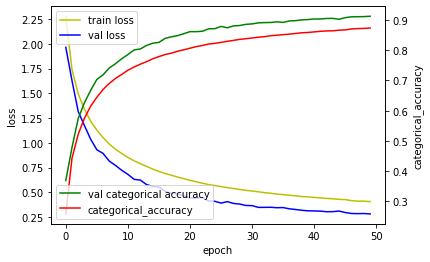

In [105]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'b', label='val loss')

acc_ax.plot(hist.history['val_categorical_accuracy'], 'g', label='val categorical accuracy')
acc_ax.plot(hist.history['categorical_accuracy'], 'r', label='categorical_accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('categorical_accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

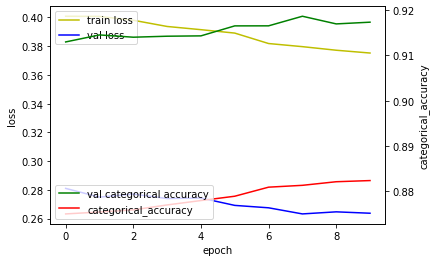

In [106]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist2.history['loss'], 'y', label='train loss')
loss_ax.plot(hist2.history['val_loss'], 'b', label='val loss')

acc_ax.plot(hist2.history['val_categorical_accuracy'], 'g', label='val categorical accuracy')
acc_ax.plot(hist2.history['categorical_accuracy'], 'r', label='categorical_accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('categorical_accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

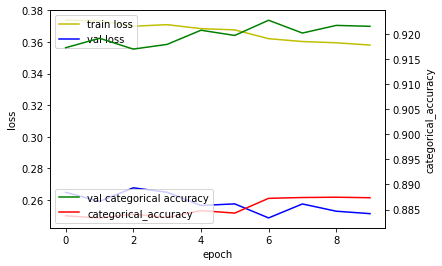

In [107]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist3.history['loss'], 'y', label='train loss')
loss_ax.plot(hist3.history['val_loss'], 'b', label='val loss')

acc_ax.plot(hist3.history['val_categorical_accuracy'], 'g', label='val categorical accuracy')
acc_ax.plot(hist3.history['categorical_accuracy'], 'r', label='categorical_accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('categorical_accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [108]:
all_hist = dict()
all_hist['loss'] = hist.history['loss'] + hist2.history['loss'] + hist3.history['loss']
all_hist['val_loss'] = hist.history['val_loss'] + hist2.history['val_loss'] + hist3.history['val_loss']
all_hist['val_categorical_accuracy'] = hist.history['val_categorical_accuracy'] + hist2.history['val_categorical_accuracy'] + hist3.history['val_categorical_accuracy']
all_hist['categorical_accuracy'] = hist.history['categorical_accuracy'] + hist2.history['categorical_accuracy'] + hist3.history['categorical_accuracy']

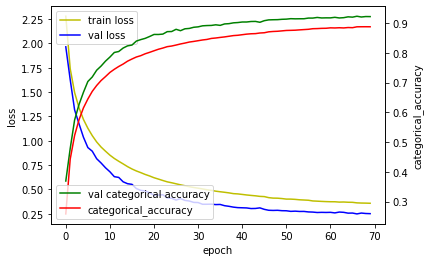

In [109]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(all_hist['loss'], 'y', label='train loss')
loss_ax.plot(all_hist['val_loss'], 'b', label='val loss')

acc_ax.plot(all_hist['val_categorical_accuracy'], 'g', label='val categorical accuracy')
acc_ax.plot(all_hist['categorical_accuracy'], 'r', label='categorical_accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('categorical_accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [110]:
model_1 = load_model('1225_cnnlstm/1225_cnnlstm_1.h5')

In [111]:
model_1.evaluate(test_X, test_y)

150000/150000 [==============================] - 73s 484us/step


[0.28277286741932234, 0.9124266505241394]

In [112]:
pred_y1 = model_1.predict(test_X, batch_size= batch)

In [113]:
ppp1 = np.argmax(pred_y1,1)
ttt = np.argmax(test_y,1)

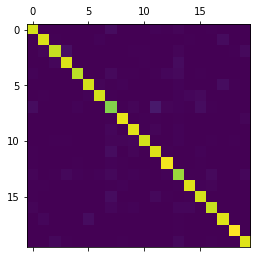

In [114]:
plt.matshow(confusion_matrix(ttt,ppp1))

In [115]:
print(classification_report(ttt, ppp1, 
                            target_names = [x for x in word_le.classes_]))

               precision    recall  f1-score   support

          bat       0.90      0.92      0.91      7500
         cake       0.95      0.92      0.93      7500
       candle       0.93      0.89      0.91      7500
       carrot       0.91      0.93      0.92      7500
   chandelier       0.95      0.88      0.91      7500
     computer       0.94      0.91      0.93      7500
        couch       0.95      0.91      0.93      7500
          dog       0.78      0.80      0.79      7500
   light bulb       0.93      0.95      0.94      7500
      mermaid       0.92      0.93      0.93      7500
   microphone       0.96      0.91      0.93      7500
       monkey       0.86      0.93      0.89      7500
      octopus       0.93      0.96      0.94      7500
       pliers       0.81      0.83      0.82      7500
         pond       0.92      0.93      0.93      7500
   sea turtle       0.89      0.92      0.90      7500
        snake       0.92      0.89      0.91      7500
   televi

In [119]:
model_2 = load_model('1225_cnnlstm/1225_cnnlstm_2.h5')

In [120]:
model_2.evaluate(test_X, test_y)

150000/150000 [==============================] - 75s 498us/step


[0.26342185292085013, 0.917959988117218]

In [121]:
pred_y2 = model_2.predict(test_X, batch_size= batch)

In [122]:
ppp2 = np.argmax(pred_y2,1)

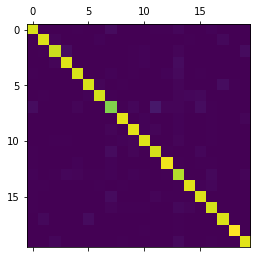

In [123]:
plt.matshow(confusion_matrix(ttt,ppp2))

In [124]:
print(classification_report(ttt, ppp2, 
                            target_names = [x for x in word_le.classes_]))

               precision    recall  f1-score   support

          bat       0.91      0.92      0.91      7500
         cake       0.95      0.93      0.94      7500
       candle       0.93      0.90      0.91      7500
       carrot       0.92      0.93      0.93      7500
   chandelier       0.92      0.92      0.92      7500
     computer       0.94      0.92      0.93      7500
        couch       0.96      0.92      0.93      7500
          dog       0.82      0.79      0.81      7500
   light bulb       0.95      0.94      0.94      7500
      mermaid       0.92      0.94      0.93      7500
   microphone       0.94      0.93      0.94      7500
       monkey       0.89      0.91      0.90      7500
      octopus       0.94      0.95      0.95      7500
       pliers       0.79      0.87      0.83      7500
         pond       0.93      0.93      0.93      7500
   sea turtle       0.89      0.92      0.91      7500
        snake       0.91      0.91      0.91      7500
   televi

In [125]:
model.evaluate(test_X, test_y) #loss, categorical_entropy, categorical_accuracy

150000/150000 [==============================] - 81s 541us/step


[0.25186119577566785, 0.9217533469200134]

In [126]:
pred_y = model.predict(test_X, batch_size= batch)

In [127]:
ppp = np.argmax(pred_y,1)

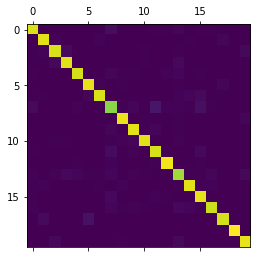

In [128]:
plt.matshow(confusion_matrix(ttt,ppp))

In [129]:
print(classification_report(ttt, ppp, 
                            target_names = [x for x in word_le.classes_]))

               precision    recall  f1-score   support

          bat       0.92      0.92      0.92      7500
         cake       0.94      0.93      0.94      7500
       candle       0.92      0.92      0.92      7500
       carrot       0.93      0.93      0.93      7500
   chandelier       0.94      0.91      0.93      7500
     computer       0.92      0.95      0.93      7500
        couch       0.96      0.92      0.94      7500
          dog       0.82      0.80      0.81      7500
   light bulb       0.94      0.95      0.94      7500
      mermaid       0.93      0.94      0.93      7500
   microphone       0.95      0.93      0.94      7500
       monkey       0.89      0.92      0.90      7500
      octopus       0.95      0.96      0.95      7500
       pliers       0.83      0.84      0.84      7500
         pond       0.93      0.93      0.93      7500
   sea turtle       0.88      0.94      0.91      7500
        snake       0.94      0.90      0.92      7500
   televi

In [236]:
CNN.add(BatchNormalization(input_shape = (None,3)))

In [237]:
CNN.output_shape

(None, None, 3)

In [238]:
CNN.add(Conv1D(64,(5,),activation = 'relu'))

In [239]:
CNN.output_shape

(None, None, 64)

In [240]:
CNN.add(MaxPooling1D())

In [241]:
CNN.output_shape

(None, None, 64)

In [242]:
CNN.add(Dropout(0.25))

In [243]:
CNN.output_shape

(None, None, 64)

In [244]:
CNN.add(Conv1D(90,(5,),activation = 'relu'))
CNN.add(MaxPooling1D())
CNN.add(Dropout(0.3))

In [245]:
CNN.output_shape

(None, None, 90)

In [246]:
CNN.add(Conv1D(64,(5,),activation = 'relu'))
CNN.add(MaxPooling1D())
CNN.add(Dropout(0.25))

In [247]:
CNN.add(LSTM(128,activation = 'relu',return_sequences = True))

In [248]:
CNN.add(Dropout(0.25))

In [249]:
CNN.output_shape

(None, None, 128)

In [250]:
CNN.add(LSTM(64,activation = 'relu',return_sequences = False))
CNN.add(Dropout(0.25))

In [251]:
CNN.add(Dense(256, activation = 'relu'))

In [252]:
CNN.add(Dense(word_num, activation = 'softmax'))

In [253]:
CNN.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy',
              metrics=[categorical_crossentropy, categorical_accuracy])

In [254]:
CNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, None, 3)           12        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 64)          1024      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 90)          28890     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 90)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 90)         

In [255]:
check_point = ModelCheckpoint('model_12120335.h5', monitor='val_loss', mode='min', save_best_only=True,
                    save_weights_only=True)
reduceRP = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=10,
                          mode='min', min_lr= 0.0001, verbose=1)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15)

callbacks = [check_point, early, reduceRP]

In [264]:
batch = 64
STEPS = 100
epochs = 100

In [265]:
hist = CNN.fit(train_X,train_y,
    batch_size = batch,
    epochs=epochs, verbose=1,
    validation_data=(valid_X, valid_y),
    callbacks = callbacks
)

Train on 245000 samples, validate on 105000 samples
Epoch 1/100
245000/245000 [==============================] - 310s 1ms/step - loss: 3.4654 - categorical_crossentropy: 3.4654 - categorical_accuracy: 0.1389 - val_loss: 2.6451 - val_categorical_crossentropy: 2.6451 - val_categorical_accuracy: 0.3107
Epoch 2/100
245000/245000 [==============================] - 330s 1ms/step - loss: 2.6023 - categorical_crossentropy: 2.6023 - categorical_accuracy: 0.3164 - val_loss: 2.0350 - val_categorical_crossentropy: 2.0350 - val_categorical_accuracy: 0.4504
Epoch 3/100
245000/245000 [==============================] - 350s 1ms/step - loss: 2.2284 - categorical_crossentropy: 2.2284 - categorical_accuracy: 0.4059 - val_loss: 1.7184 - val_categorical_crossentropy: 1.7184 - val_categorical_accuracy: 0.5321
Epoch 4/100
245000/245000 [==============================] - 322s 1ms/step - loss: 2.0151 - categorical_crossentropy: 2.0151 - categorical_accuracy: 0.4591 - val_loss: 1.5441 - val_categorical_crossent

KeyboardInterrupt: 

### fit_generator 다시 사용해보기

In [168]:
inp = Input(shape=(200,3))
model = ResNet50(input_tensor=inp, include_top=False, weights=None, pooling='max')

ValueError: Shape must be rank 4 but is rank 3 for 'conv1_pad_10/Pad' (op: 'Pad') with input shapes: [?,200,3], [4,2].

In [152]:
CNN = Sequential()

In [157]:
RESNET =ResNet50(include_top = False, weights = 'imagenet',
                 input_tensor = None, 
                 input_shape =(None,3), 
                 pooling=None)

ValueError: `input_shape` must be a tuple of three integers.

In [154]:
CNN.add(RESNET)

In [155]:
CNN.add(MaxPooling2D())

In [156]:
CNN.output_shape

(None, None, None, 2048)

In [140]:
CNN.add(MaxPooling2D())
CNN.add(Flatten())

ValueError: The shape of the input to "Flatten" is not fully defined (got (None, None, 2048)). Make sure to pass a complete "input_shape" or "batch_input_shape" argument to the first layer in your model.

In [38]:
hist.history.keys()

dict_keys(['val_loss', 'val_categorical_crossentropy', 'val_categorical_accuracy', 'loss', 'categorical_crossentropy', 'categorical_accuracy', 'lr'])

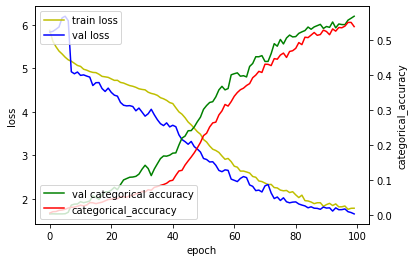

In [39]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'b', label='val loss')

acc_ax.plot(hist.history['val_categorical_accuracy'], 'g', label='val categorical accuracy')
acc_ax.plot(hist.history['categorical_accuracy'], 'r', label='categorical_accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('categorical_accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

## Evaluation

In [40]:
pred_y = model.predict(test_X, batch_size= batch)

In [41]:
ppp = np.argmax(pred_y,1)

In [42]:
ttt = np.argmax(test_y,1)

In [43]:
ppp

array([115, 329,  27, ...,  50, 306, 181], dtype=int64)

In [44]:
ttt

array([115, 329, 300, ...,  50, 210, 181], dtype=int64)

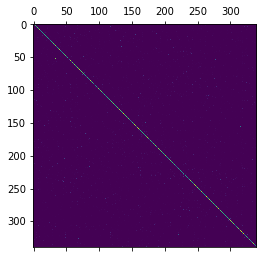

In [45]:
plt.matshow(confusion_matrix(ttt,ppp))

In [48]:
part1 = classification_report(ttt, ppp, 
                            target_names = [x for x in word_le.classes_])

* 이미지 그리기

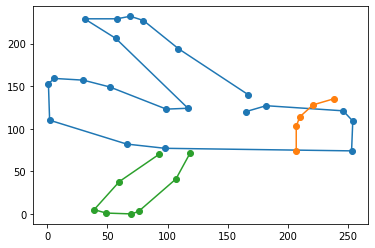

In [122]:
raw_images = list(all_data['drawing'])

k = 0
for i in range(len(raw_images[k])):
    plt.plot(raw_images[k][i][0], raw_images[k][i][1],'o-')
plt.show()

In [171]:
def get_Xy(in_df):
    X = np.stack(in_df['drawing'], 0)
    y = to_categorical(word_encoder.transform(in_df['word'].values))
    return X, y
train_X, train_y = get_Xy(train_df)
valid_X, valid_y = get_Xy(valid_df)
test_X, test_y = get_Xy(test_df)
print(train_X.shape)

NameError: name 'train_df' is not defined

In [108]:

stroke_read_model = Sequential()
stroke_read_model.add(BatchNormalization(input_shape = (None,)))
# filter count and length are taken from the script https://github.com/tensorflow/models/blob/master/tutorials/rnn/quickdraw/train_model.py
stroke_read_model.add(Conv1D(48, (5,)))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(Conv1D(64, (5,)))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(Conv1D(96, (3,)))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(LSTM(128, return_sequences = True))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(LSTM(128, return_sequences = False))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(Dense(512))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(Dense(len(word_encoder.classes_), activation = 'softmax'))
stroke_read_model.compile(optimizer = 'adam', 
                          loss = 'categorical_crossentropy', 
                          metrics = ['categorical_accuracy', top_3_accuracy])
stroke_read_model.summary()

ValueError: Axis -1 of input tensor should have a defined dimension but the layer received an input with shape (None, None).